In [1]:
import numpy as np
from pathlib import Path
import glob
import os

import matplotlib.pyplot as plt
import random
from scipy.signal import savgol_filter
from scipy.signal import resample

import pickle

In [2]:
date_id = "20250319"
i = "303"
data_path = f"/home/predator/Documents/redpitaya_ws/datasets/collected_data/s{date_id}"
saved_data_path = f"/home/predator/Documents/redpitaya_ws/datasets/saved_data/"
os.makedirs(saved_data_path, exist_ok=True)

In [3]:
def load_data(fullname):
    with open(fullname, 'rb') as fd:
          data = pickle.load(fd)
          fd.close()
    return data

def scaledata(data):
    settings = data['settings']
    trace = np.frombuffer(data['data'], dtype='>u2')
    gain = float(settings.split("YINC:")[1].split("\n")[0])
    offset = float(settings.split("YOR:")[1].split("\n")[0])
    trace = trace * gain - offset
    return(trace)
    
def savitzky (data):
    return(savgol_filter(data, 200, 3))

# def resampling(signal,f,f2):
#     signal_resampled = resample(signal, int(len(signal) * f2 / f))
#     return (signal_resampled)

def melting_data(d1,d2,d3):
    temp=list(zip(d1,d2,d3))
    random.shuffle(temp)
    d1,d2,d3=zip(*temp)
    d1=np.array(d1)
    d2=np.array(d2)
    d3=np.array(d3)
    return([d1,d2,d3])

In [4]:
liste_ch1 = sorted(glob.glob(data_path+'/s20250319_*_ch{}.pickle'.format(1))) #modality 1 1310nm
liste_ch2 = sorted(glob.glob(data_path+'/s20250319_*_ch{}.pickle'.format(2)))#modality 2   405nm modulate
liste_ch3 = sorted(glob.glob(data_path+'/s20250319_*_ch{}.pickle'.format(3)))#displacement
liste_ch4 = sorted(glob.glob(data_path+'/s20250319_*_ch{}.pickle'.format(4)))#modulation

In [5]:
print(len(liste_ch1))
print(len(liste_ch2))
print(len(liste_ch3))

32
32
32


sampling frequency: 109170.30567685589 Hz
sampling time: 9.16e-06 s
109 points per segment


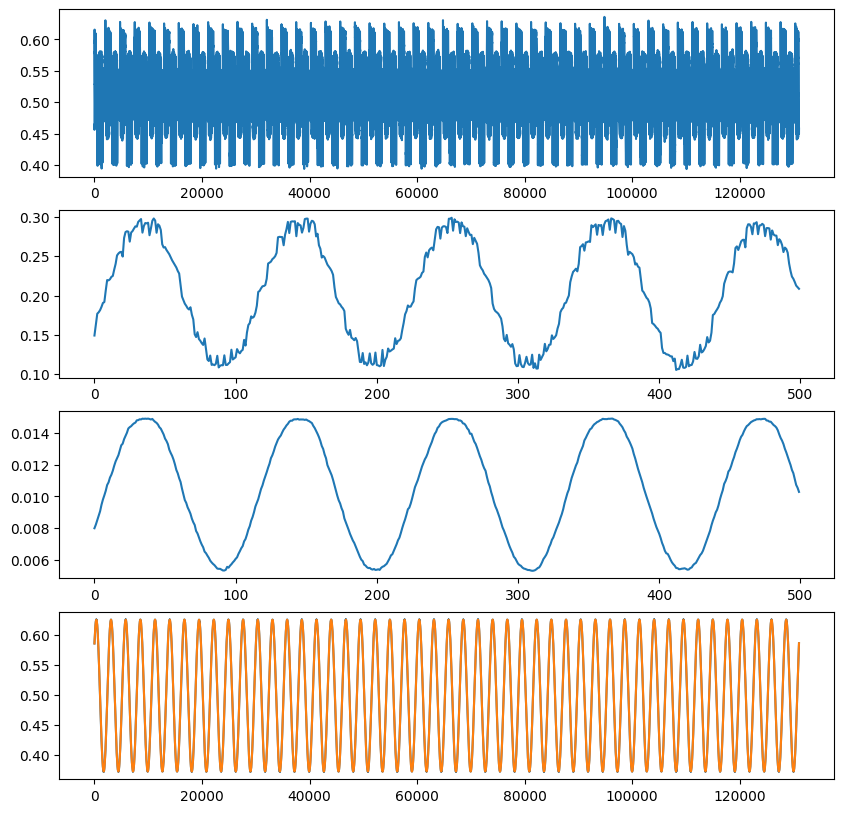

In [6]:
i=303 #300-->309

file1 = [f for f in liste_ch1 if f"s20250319_{i}_rtb_ch1.pickle" in f][0]
data1=scaledata(load_data(file1))

file2 = [f for f in liste_ch2 if f"s20250319_{i}_rtb_ch2.pickle" in f][0]
data2=scaledata(load_data(file2))

file3 = [f for f in liste_ch3 if f"s20250319_{i}_rtb_ch3.pickle" in f][0]
data3=scaledata(load_data(file3))

file4 = [f for f in liste_ch4 if f"s20250319_{i}_rtb_ch4.pickle" in f][0]
data4=scaledata(load_data(file4))

print("sampling frequency:",1/float(load_data(file1)['settings'].split("XINC:")[1].split("\n")[0]), "Hz")
print("sampling time:", float(load_data(file1)['settings'].split("XINC:")[1].split("\n")[0]), "s")
print(int(1e-3//float(load_data(file1)['settings'].split("XINC:")[1].split("\n")[0])),"points per segment")

plt.figure(figsize=(10,10))
plt.subplot(411)
plt.plot(data1)
plt.subplot(412)
plt.plot(data2[:500])
plt.subplot(413)
plt.plot(data4[:500])
plt.subplot(414)
plt.plot(data3)
plt.plot(savitzky(data3))

In [7]:
n_pts=int(1e-3//float(load_data(file1)['settings'].split("XINC:")[1].split("\n")[0]))
print(n_pts)
data_len='long' #'short or 'long'

# n_pts=256

109


In [8]:
output_dir = f'{saved_data_path}/npy/s{date_id}/s{date_id}_{i}/{n_pts}/Exp_1310_405M'
os.makedirs(output_dir, exist_ok=True)

In [9]:
displacement=[]
Mode1=[]
Mode2=[]
for i in range (300,310):
    file = [f for f in liste_ch1 if f"s20250319_{i}_rtb_ch1.pickle" in f][0]
    
    sampling_time=float(load_data(file)['settings'].split("XINC:")[1].split("\n")[0])
    print("Xinc:",sampling_time, 's')
    print("Sampling frequency:",1/sampling_time, 'Hz')
    
    moda1=scaledata(load_data(file))
    if data_len=='long':
        moda1 = np.concatenate([np.array(moda1[:len(moda1)-len(moda1)%n_pts]), np.array(moda1[128:len(moda1)-(len(moda1)-128)%n_pts])])
    moda1 =np.array(moda1[:len(moda1)-len(moda1)%n_pts])
    X1=len(moda1)//n_pts
    moda1=np.reshape(moda1,(X1,n_pts,1))
    Mode1=Mode1+[moda1]

        
    file = [f for f in liste_ch2 if f"s20250319_{i}_rtb_ch2.pickle" in f][0]
    moda2=scaledata(load_data(file))
    if data_len=='long':
        moda2 = np.concatenate([np.array(moda2[:len(moda2)-len(moda2)%n_pts]), np.array(moda2[128:len(moda2)-(len(moda2)-128)%n_pts])])
    moda2 =np.array(moda2[:len(moda2)-len(moda2)%n_pts])
    X2=len(moda2)//n_pts
    moda2=np.reshape(moda2,(X2,n_pts,1))
    Mode2=Mode2+[moda2]
    

    file = [f for f in liste_ch3 if f"s20250319_{i}_rtb_ch3.pickle" in f][0]
    disp=scaledata(load_data(file))
    disp=savitzky(disp)
    if data_len=='long':
        disp = np.concatenate([np.array(disp[:len(disp)-len(disp)%n_pts]), np.array(disp[128:len(disp)-(len(disp)-128)%n_pts])])
    disp =np.array(disp[:len(disp)-len(disp)%n_pts])
    X=len(disp)//n_pts
    disp=np.reshape(disp,(X,n_pts))
    train_displacement=[disp[i,n_pts-1]-disp[i,0] for i in range (X)]
    train_displacement=np.reshape(train_displacement,(X,1))
    displacement= displacement+[train_displacement]


a=len(np.array(Mode1))
b=len(np.array(Mode1[0]))

displacement=np.array(displacement).reshape(a*b,1)

Mode1=np.array(Mode1).reshape(a*b,n_pts,1)

Mode2=np.array(Mode2).reshape(a*b,n_pts,1)

Xinc: 9.16e-06 s
Sampling frequency: 109170.30567685589 Hz
Xinc: 9.16e-06 s
Sampling frequency: 109170.30567685589 Hz
Xinc: 9.16e-06 s
Sampling frequency: 109170.30567685589 Hz
Xinc: 9.16e-06 s
Sampling frequency: 109170.30567685589 Hz
Xinc: 9.16e-06 s
Sampling frequency: 109170.30567685589 Hz
Xinc: 9.16e-06 s
Sampling frequency: 109170.30567685589 Hz
Xinc: 9.16e-06 s
Sampling frequency: 109170.30567685589 Hz
Xinc: 9.16e-06 s
Sampling frequency: 109170.30567685589 Hz
Xinc: 9.16e-06 s
Sampling frequency: 109170.30567685589 Hz
Xinc: 9.16e-06 s
Sampling frequency: 109170.30567685589 Hz


In [10]:
print(Mode2.shape)
print(Mode1.shape)
print(displacement.shape)

(24010, 109, 1)
(24010, 109, 1)
(24010, 1)


In [11]:
unique_mode2, unique_indices = np.unique(Mode2, axis=0, return_index=True)
sorted_indices = np.sort(unique_indices)
Mode2= Mode2[sorted_indices]


Mode1=Mode1[sorted_indices]
displacement=displacement[sorted_indices]

In [12]:
print(Mode2.shape)
print(Mode1.shape)
print(displacement.shape)

(24010, 109, 1)
(24010, 109, 1)
(24010, 1)


In [13]:
mel_train=melting_data(Mode1,Mode2,displacement)
Mode1,Mode2,displacement=mel_train[0],mel_train[1],mel_train[2]

Text(0.5, 1.0, 'Velocity histogram training datas')

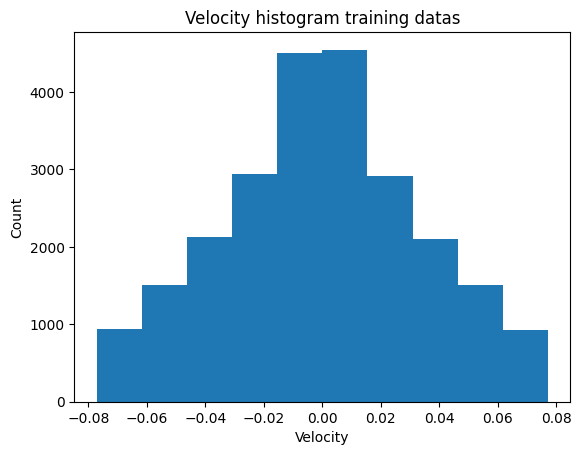

In [14]:
plt.figure()
plt.hist(displacement)
plt.xlabel("Velocity")
plt.ylabel("Count")
plt.title("Velocity histogram training datas")

In [15]:
p=0.1
test_simi_mode1=Mode1[:int(len(Mode1)*p)]
test_simi_mode2=Mode2[:int(len(Mode2)*p)]
test_simi_displacement=displacement[:int(len(displacement)*p)]

In [16]:
Mode1=Mode1[int(len(Mode1)*p):]
Mode2=Mode2[int(len(Mode2)*p):]
displacement=displacement[int(len(displacement)*p):]

In [17]:
print(Mode2.shape)
print(Mode1.shape)
print(displacement.shape)

(21609, 109, 1)
(21609, 109, 1)
(21609, 1)


In [18]:
print(test_simi_mode1.shape)
print(test_simi_mode2.shape)
print(test_simi_displacement.shape)

(2401, 109, 1)
(2401, 109, 1)
(2401, 1)


In [19]:
np.save(f'{output_dir}/M1_SM_signals_training_{data_len}.npy', Mode1)
np.save(f'{output_dir}/M2_SM_signals_training_{data_len}.npy', Mode2)
np.save(f'{output_dir}/Displacement_training_{data_len}.npy', displacement)

In [20]:
np.save(f'{output_dir}/M1_SM_signals_test_simi_{data_len}.npy', test_simi_mode1)
np.save(f'{output_dir}/M2_SM_signals_test_simi_{data_len}.npy', test_simi_mode2)
np.save(f'{output_dir}/Displacement_test_simi_{data_len}.npy', test_simi_displacement)

# Test

In [21]:
liste_ch1 = sorted(glob.glob(data_path+'/s20250319_*_ch{}.pickle'.format(1))) #modality 1
liste_ch2 = sorted(glob.glob(data_path+'/s20250319_*_ch{}.pickle'.format(2)))#modality 2
liste_ch3 = sorted(glob.glob(data_path+'/s20250319_*_ch{}.pickle'.format(3)))#displacement
liste_ch4 = sorted(glob.glob(data_path+'/s20250319_*_ch{}.pickle'.format(4)))#modulation

In [22]:
i=320
test_file1 = [f for f in liste_ch1 if f"s20250319_{i}_rtb_ch1.pickle" in f][0]

sampling_time=float(load_data(test_file1)['settings'].split("XINC:")[1].split("\n")[0])
print("Xinc:",sampling_time, 's')
    
test_moda1=scaledata(load_data(test_file1))
test_moda1 =np.array(test_moda1[:len(test_moda1)-len(test_moda1)%n_pts])
test_X1=len(test_moda1)//n_pts
test_moda1=np.reshape(test_moda1,(test_X1,n_pts,1))

        
test_file2 = [f for f in liste_ch2 if f"s20250319_{i}_rtb_ch2.pickle" in f][0]
test_moda2=scaledata(load_data(test_file2))
test_moda2 =np.array(test_moda2[:len(test_moda2)-len(test_moda2)%n_pts])
test_X2=len(test_moda2)//n_pts
test_moda2=np.reshape(test_moda2,(test_X2,n_pts,1))



test_file3 = [f for f in liste_ch3 if f"s20250319_{i}_rtb_ch3.pickle" in f][0]
test_disp=scaledata(load_data(test_file3))
test_disp=savitzky(test_disp)
test_disp =np.array(test_disp[:len(test_disp)-len(test_disp)%n_pts])
test_X=len(test_disp)//n_pts
test_disp=np.reshape(test_disp,(test_X,n_pts))
test_displacement=[test_disp[i,n_pts-1]-test_disp[i,0] for i in range (test_X)]
test_displacement=np.reshape(test_displacement,(test_X,1))

    
print(test_moda1.shape)
print(test_moda2.shape)
print(test_displacement.shape)

Xinc: 9.16e-06 s
(1201, 109, 1)
(1201, 109, 1)
(1201, 1)


Text(0.5, 1.0, 'Velocity histogram test datas')

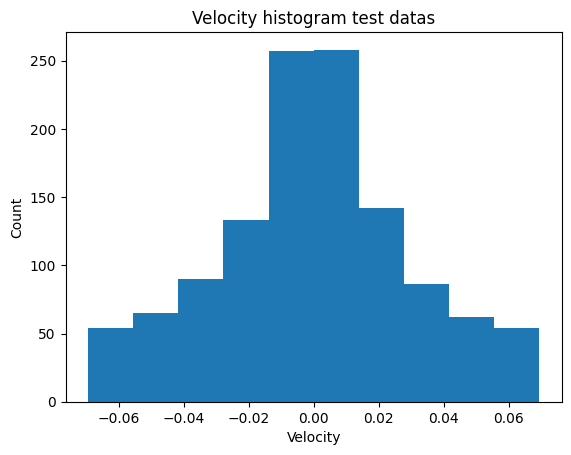

In [23]:
plt.figure()
plt.hist(test_displacement)
plt.xlabel("Velocity")
plt.ylabel("Count")
plt.title("Velocity histogram test datas")

In [24]:
np.save(f'{output_dir}/M1_SM_signals_test_{data_len}.npy', test_moda1)
np.save(f'{output_dir}/M2_SM_signals_test_{data_len}.npy', test_moda2)
np.save(f'{output_dir}/Displacement_test_{data_len}.npy', test_displacement)

In [25]:
# np.save('../datas/Exp_1310_405/M1_Test_SM_+',test_moda1)
# np.save('../datas/Exp_1310_405/Displacement_test_+.npy',test_displacement)